## Load in dependencies

In [ ]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data science
import pandas as pd
import numpy as np
from scipy import stats

# Imbalanced Data
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

# Machine Learning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFwe
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle
import datetime

# Path to data folder with provided material
data_path = '../'

## Response Variable

In [ ]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('C:/Users/Shall We Dance/Stat432project/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

In [ ]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs('C:/Users/Shall We Dance/Stat432project/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

gbifID  eventDate    country  continent    stateProvince  \
935     3108894201 2017-11-12  Australia  Australia  New South Wales   
941     3108882429 2019-09-19  Australia  Australia  New South Wales   
944     3108953063 2019-11-03  Australia  Australia  New South Wales   
945     3108952573 2019-11-04  Australia  Australia  New South Wales   
980     1452200212 2015-06-16  Australia  Australia  New South Wales   
...            ...        ...        ...        ...              ...   
193471  3108863070 2018-11-13  Australia  Australia  New South Wales   
193473  3108900314 2019-10-30  Australia  Australia  New South Wales   
193476  3108938525 2018-10-17  Australia  Australia  New South Wales   
193477  3108845537 2019-10-15  Australia  Australia  New South Wales   
193735  1653525892 2015-09-15  Australia  Australia  New South Wales   

        decimalLatitude  decimalLongitude           species  
935          -33.699881        151.043367    Litoria Fallax  
941          -33.955790        150.976815  Crinia Signifera  
944          -33.755278        150.623221    Litoria Fallax  
945          -33.755291        150.623651    Litoria Fallax  
980          -33.951844        150.870430    Litoria Fallax  
...                 ...               ...               ...  
193471       -33.474900        150.172000  Crinia Signifera  
193473       -33.789908        151.131394    Litoria Fallax  
193476       -33.757622        150.618240    Litoria Fallax  
193477       -33.718800        150.385000  Crinia Signifera  
193735       -33.767500        151.117917  Crinia Signifera  

[9418 rows x 8 columns]

### Addressing bias

In [ ]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'))
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of the area. Here, only two of the five Australian species are present: crinia signifera, the common eastern froglet, and litoria fallax, the eastern dwarf tree frog.

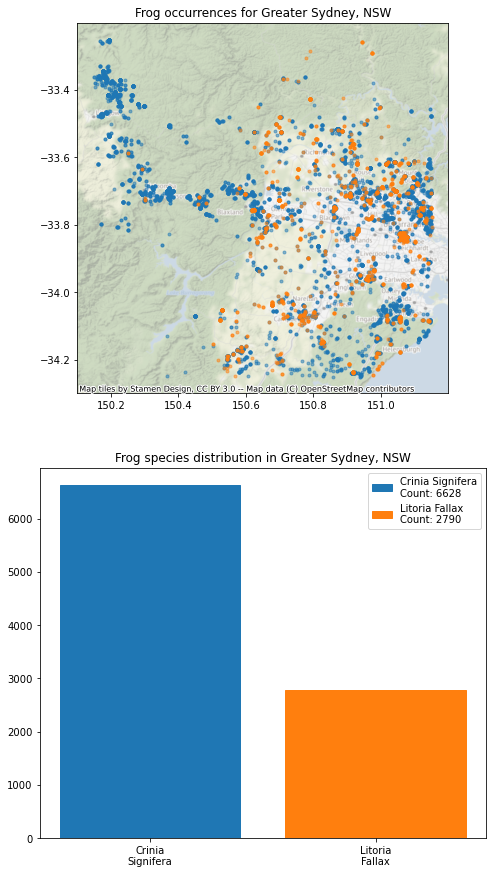

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

In [ ]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

gbifID  eventDate    country  continent    stateProvince  \
935     3108894201 2017-11-12  Australia  Australia  New South Wales   
941     3108882429 2019-09-19  Australia  Australia  New South Wales   
944     3108953063 2019-11-03  Australia  Australia  New South Wales   
945     3108952573 2019-11-04  Australia  Australia  New South Wales   
980     1452200212 2015-06-16  Australia  Australia  New South Wales   
...            ...        ...        ...        ...              ...   
193471  3108863070 2018-11-13  Australia  Australia  New South Wales   
193473  3108900314 2019-10-30  Australia  Australia  New South Wales   
193476  3108938525 2018-10-17  Australia  Australia  New South Wales   
193477  3108845537 2019-10-15  Australia  Australia  New South Wales   
193735  1653525892 2015-09-15  Australia  Australia  New South Wales   

        decimalLatitude  decimalLongitude           species  occurrenceStatus  
935          -33.699881        151.043367    Litoria Fallax                 1  
941          -33.955790        150.976815  Crinia Signifera                 0  
944          -33.755278        150.623221    Litoria Fallax                 1  
945          -33.755291        150.623651    Litoria Fallax                 1  
980          -33.951844        150.870430    Litoria Fallax                 1  
...                 ...               ...               ...               ...  
193471       -33.474900        150.172000  Crinia Signifera                 0  
193473       -33.789908        151.131394    Litoria Fallax                 1  
193476       -33.757622        150.618240    Litoria Fallax                 1  
193477       -33.718800        150.385000  Crinia Signifera                 0  
193735       -33.767500        151.117917  Crinia Signifera                 0  

[9418 rows x 9 columns]

Text(0.5, 1.0, 'Training set for Greater Sydney, NSW')

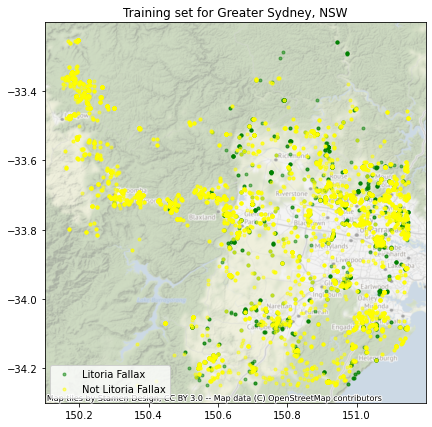

In [ ]:
frog_data = all_frog_data.reset_index(drop=True).assign(key=lambda x: x.index)

fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

## Predictor Variables
We will take four metrics, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

In [ ]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [ ]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

### Visualising the TerraClimate Data

The spatial distribution of the four variables are displayed below.

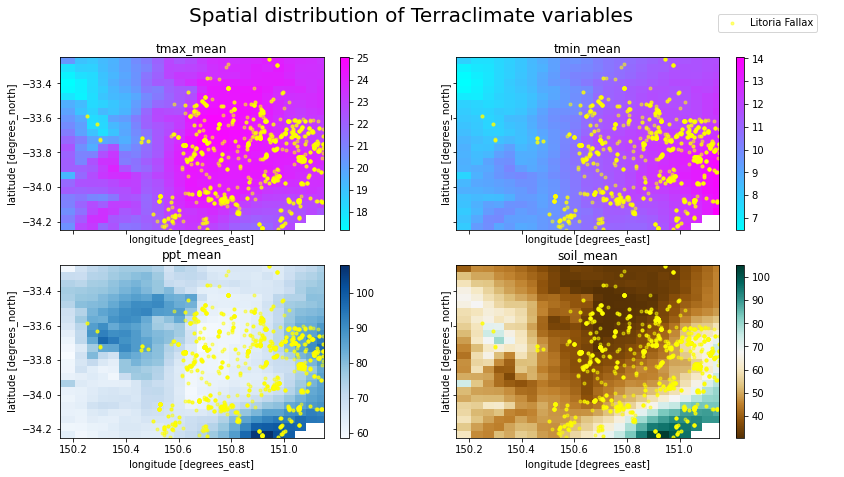

In [ ]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [ ]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(frog_data, weather_data)
model_data

gbifID  eventDate    country  continent    stateProvince  \
0     3108894201 2017-11-12  Australia  Australia  New South Wales   
1     3108882429 2019-09-19  Australia  Australia  New South Wales   
2     3108953063 2019-11-03  Australia  Australia  New South Wales   
3     3108952573 2019-11-04  Australia  Australia  New South Wales   
4     1452200212 2015-06-16  Australia  Australia  New South Wales   
...          ...        ...        ...        ...              ...   
9413  3108863070 2018-11-13  Australia  Australia  New South Wales   
9414  3108900314 2019-10-30  Australia  Australia  New South Wales   
9415  3108938525 2018-10-17  Australia  Australia  New South Wales   
9416  3108845537 2019-10-15  Australia  Australia  New South Wales   
9417  1653525892 2015-09-15  Australia  Australia  New South Wales   

      decimalLatitude  decimalLongitude           species  occurrenceStatus  \
0          -33.699881        151.043367    Litoria Fallax                 1   
1          -33.955790        150.976815  Crinia Signifera                 0   
2          -33.755278        150.623221    Litoria Fallax                 1   
3          -33.755291        150.623651    Litoria Fallax                 1   
4          -33.951844        150.870430    Litoria Fallax                 1   
...               ...               ...               ...               ...   
9413       -33.474900        150.172000  Crinia Signifera                 0   
9414       -33.789908        151.131394    Litoria Fallax                 1   
9415       -33.757622        150.618240    Litoria Fallax                 1   
9416       -33.718800        150.385000  Crinia Signifera                 0   
9417       -33.767500        151.117917  Crinia Signifera                 0   

       key   ppt_mean  soil_mean  tmax_mean  tmin_mean  
0        0  85.166664  61.250000  23.146669  12.186667  
1        1  66.983330  53.316666  23.998333  12.873335  
2        2  67.966667  37.950001  23.875002  10.618335  
3        3  67.966667  37.950001  23.875002  10.618335  
4        4  63.099998  46.366665  24.253334  12.241668  
...    ...        ...        ...        ...        ...  
9413  9413  73.349998  65.083336  17.966669   7.081669  
9414  9414  90.416664  72.550003  23.373333  13.133334  
9415  9415  67.966667  37.950001  23.875002  10.618335  
9416  9416  91.099998  62.683334  19.626669   8.335001  
9417  9417  84.050003  65.483330  23.581669  13.054999  

[9418 rows x 14 columns]

## Exploratory Data Analysis and Feature Engineering

Explore continuous and categorical variables separately

### Continuous Variables EDA and Feature Engineering

#### Location variables

In [ ]:
# Add two new variables based on the latitude and longitude features
# https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796
model_data['loc_sumsquare'] = np.sqrt(model_data['decimalLatitude']**2 + model_data['decimalLongitude']**2)
model_data['loc_atan2'] = np.arctan2(model_data['decimalLatitude'],model_data['decimalLongitude'])

In [ ]:
# List and describe all the continuous variables 
cont_variables = ["species","decimalLatitude","decimalLongitude","ppt_mean","soil_mean","tmax_mean","tmin_mean","loc_sumsquare","loc_atan2"]
cont_model_data = model_data.loc[:,cont_variables]
cont_model_data.describe()

decimalLatitude  decimalLongitude     ppt_mean    soil_mean  \
count      9418.000000       9418.000000  9418.000000  9418.000000   
mean        -33.774927        150.805720    75.340248    55.048435   
std           0.203942          0.295894     9.932862    15.187789   
min         -34.249929        150.150402    59.283333    30.616667   
25%         -33.841313        150.623268    67.966667    42.200001   
50%         -33.756317        150.918000    73.933334    56.266666   
75%         -33.675679        151.062409    82.516670    62.683334   
max         -33.251121        151.150000   107.949997   105.150002   

         tmax_mean    tmin_mean  loc_sumsquare    loc_atan2  
count  9418.000000  9418.000000    9418.000000  9418.000000  
mean     22.864126    11.352835     154.541721    -0.220327  
std       1.984061     1.955527       0.310490     0.001171  
min      17.160002     6.461668     153.805984    -0.223946  
25%      22.821669    10.618335     154.359527    -0.220628  
50%      23.786665    11.918336     154.645301    -0.220346  
75%      23.933336    12.873335     154.805678    -0.219519  
max      25.020002    14.045002     154.942023    -0.216864

#### Outlier Detection

In [ ]:
def boxplot(df,column):
    sns.boxplot(data=df,x=df[f"{column}"])
    plt.title(f"Boxplot of model variable {column}")

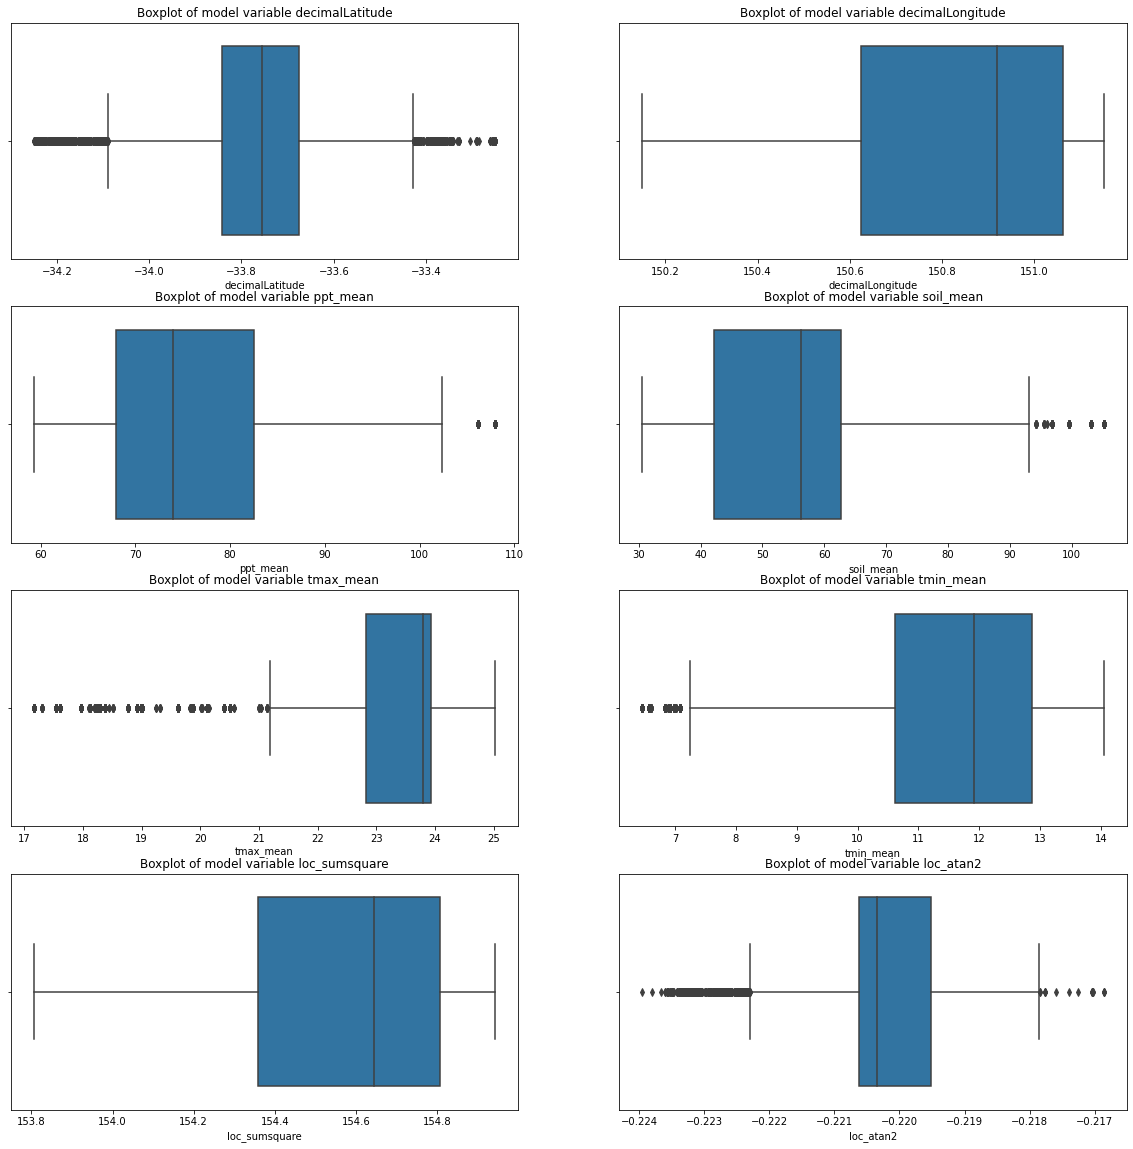

In [ ]:
# Check the boxplots of all the continuous variables
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
boxplot(cont_model_data,'decimalLatitude')
plt.subplot(4,2,2)
boxplot(cont_model_data,'decimalLongitude')
plt.subplot(4,2,3)
boxplot(cont_model_data,'ppt_mean')
plt.subplot(4,2,4)
boxplot(cont_model_data,'soil_mean')
plt.subplot(4,2,5)
boxplot(cont_model_data,'tmax_mean')
plt.subplot(4,2,6)
boxplot(cont_model_data,'tmin_mean')
plt.subplot(4,2,7)
boxplot(cont_model_data,'loc_sumsquare')
plt.subplot(4,2,8)
boxplot(cont_model_data,'loc_atan2')

#### PairPlot

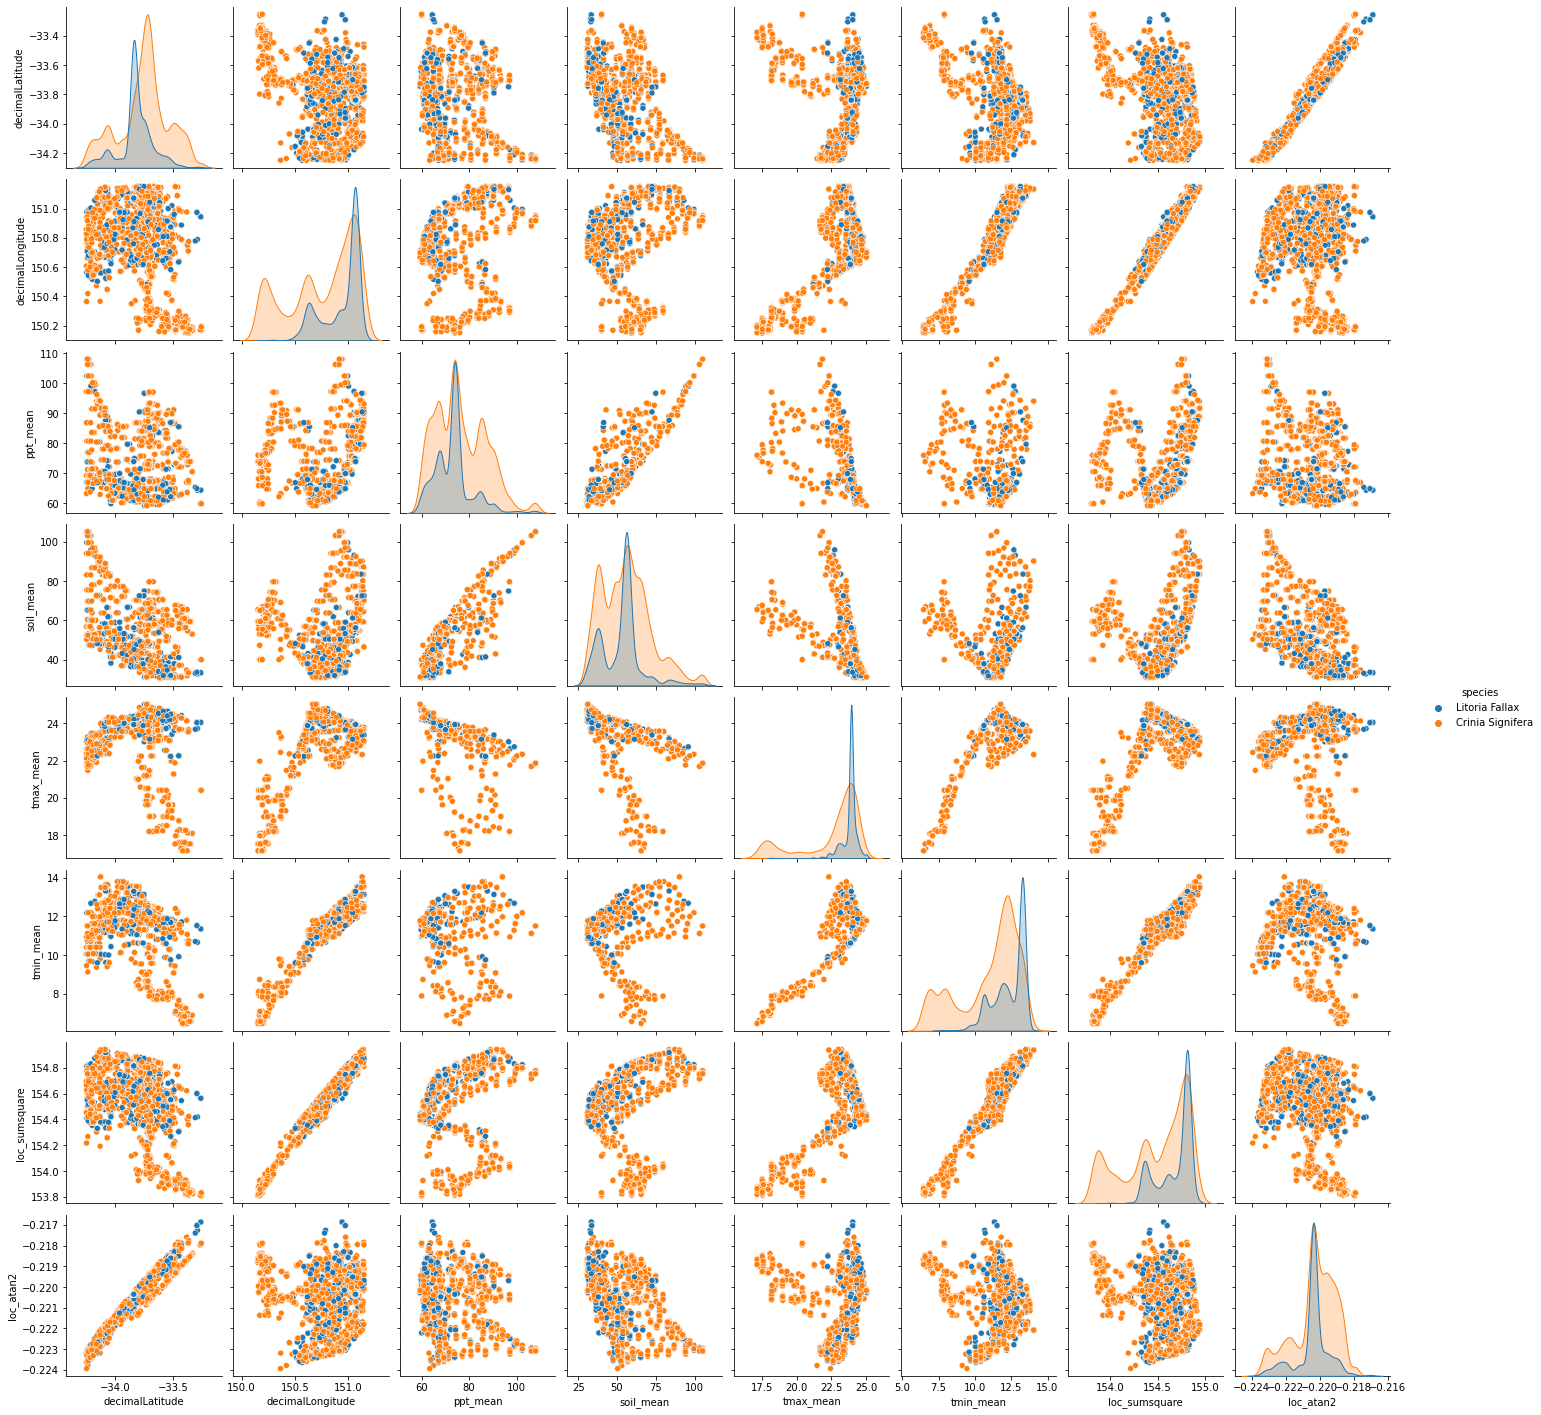

In [ ]:
# Create the pairplot for the continuous variables
sns.pairplot(cont_model_data, hue="species")

- ppt_mean and soil_mean follow a right skewed distribution

- tmax_mean follows a left skewed distribution

- tmin_mean follows a bimodal distribution

We need to perform transformations for those variables if we decide to run linear models

#### Correlation Analysis

<AxesSubplot:>

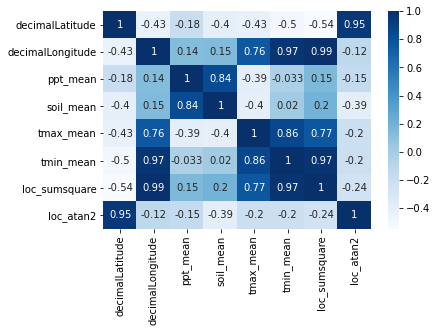

In [ ]:
sns.heatmap(cont_model_data.corr(), annot=True,cmap="Blues")

- soil_mean is strongly positively correlated with ppt_mean

- tmax_mean is strongly and positively correalted with decimalLongitude

- tmin_mean is strongly and positively correlated with decimalLongitude and tmax_min

- loc_sumsquare is strongly and positively correlated with decimalLongitude, tmin_mean and tmax_min

- loc_atan2 is strongly and positively correlated with decimalLatitude

We need to be aware of the collinearity problems when runing linear models

#### T test

In [ ]:
def get_t_test(cont_model_data,column):
    # Random select 1500 samples
    data_temp = cont_model_data.sample(n=1500,random_state=8)
    # Subset data
    species1 = data_temp[data_temp.species == "Litoria Fallax"][column]
    species2 = data_temp[data_temp.species == "Crinia Signifera"][column]
    # Check the normality of data
    if (stats.shapiro(species1)[1] < 0.05)|(stats.shapiro(species2)[1] < 0.05):
        return "Feature does not follow a normal distribution"
    # Check the homogeneity of variances
    elif stats.levene(species1, species2)[1] < 0.05:
        res = stats.ttest_ind(male, female, equal_var=False)
        return display(res)
    else:
        res = stats.ttest_ind(male, female, equal_var=False)
        return display(res)

In [ ]:
# Get the t test results for all the continuous variables
for i in cont_variables[1:]:
    print("For %s \n"%(i) + get_t_test(cont_model_data,i))

For decimalLatitude 
Feature does not follow a normal distribution
For decimalLongitude 
Feature does not follow a normal distribution
For ppt_mean 
Feature does not follow a normal distribution
For soil_mean 
Feature does not follow a normal distribution
For tmax_mean 
Feature does not follow a normal distribution
For tmin_mean 
Feature does not follow a normal distribution
For loc_sumsquare 
Feature does not follow a normal distribution
For loc_atan2 
Feature does not follow a normal distribution


None of the variables follows a normal distribution (which matches the result from the pairplot) therefore we are not able to perform t test without variable transformation

### Categorical Variable EDA and Feature Engineering

#### Date Variables

In [ ]:
# Split the date into weekday, month and year
model_data['weekday'] = model_data['eventDate'].apply(lambda x:x.weekday()+1)
model_data['month'] = model_data['eventDate'].apply(lambda x:x.month)
model_data['year'] = model_data['eventDate'].apply(lambda x:x.year)
model_data[["species","eventDate","weekday","month","year"]].head()

species  eventDate  weekday  month  year
0    Litoria Fallax 2017-11-12        7     11  2017
1  Crinia Signifera 2019-09-19        4      9  2019
2    Litoria Fallax 2019-11-03        7     11  2019
3    Litoria Fallax 2019-11-04        1     11  2019
4    Litoria Fallax 2015-06-16        2      6  2015

#### K-mean Clustering

In [ ]:
# List all the variables for k-mean clustering
kmean_variables = ['decimalLatitude','decimalLongitude','ppt_mean','soil_mean','tmax_mean','tmin_mean']
kmean_model_data = model_data.loc[:,kmean_variables]
kmean_model_data.head()

decimalLatitude  decimalLongitude   ppt_mean  soil_mean  tmax_mean  \
0       -33.699881        151.043367  85.166664  61.250000  23.146669   
1       -33.955790        150.976815  66.983330  53.316666  23.998333   
2       -33.755278        150.623221  67.966667  37.950001  23.875002   
3       -33.755291        150.623651  67.966667  37.950001  23.875002   
4       -33.951844        150.870430  63.099998  46.366665  24.253334   

   tmin_mean  
0  12.186667  
1  12.873335  
2  10.618335  
3  10.618335  
4  12.241668

In [ ]:
def cluster_plot(data, k_range=range(2, 12), n_init=5, sample_size=2000):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=n_init,random_state=432)
        kmeans.fit(data)
        sil = silhouette_score(data, kmeans.labels_, 
                               sample_size=sample_size)
        scores.append([k, kmeans.inertia_, sil])

    scores_df = pd.DataFrame(scores, columns=['k','sum_square_dist', 'sil'])
    plt.figure(figsize=[10, 8])
    plt.subplot(211, xlabel='Within Group Error')
    plt.plot(scores_df.k, scores_df.sum_square_dist)
    plt.subplot(212, xlabel='Between Group Error (Silhouette Score)')
    plt.plot(scores_df.k, scores_df.sil)
    plt.show()

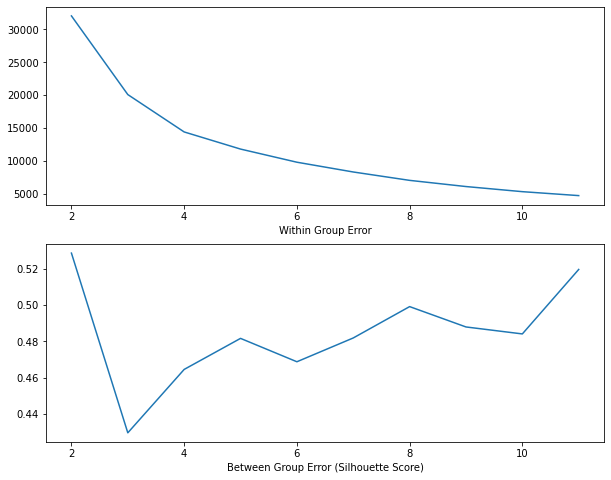

In [ ]:
# Scale the data
scale_kmean_model_data=scale(kmean_model_data)

# Check the between group and within group plots
models=cluster_plot(scale_kmean_model_data)
models

In [ ]:
# Get the variation when k = 2
scores = []
kmeans = KMeans(n_clusters=2, n_init=5,random_state=432)
kmeans.fit(scale_kmean_model_data)
sil = silhouette_score(scale_kmean_model_data, kmeans.labels_, 
                       sample_size=2000)
scores.append([kmeans.inertia_, sil])

scores_df = pd.DataFrame(scores, columns=['sum_square_dist', 'sil'])
scores_df

sum_square_dist       sil
0     32053.456181  0.527257

In [ ]:
# Perform K-mean clustering given k=2
def k_means(data, k, n_init=5):
    model = KMeans(n_clusters=k, n_init=n_init,random_state=432)
    model.fit(data)
    return model.labels_

labels = k_means(scale_kmean_model_data,k=2)

In [ ]:
# Add the label to the orignial data set.
model_data = model_data.join(pd.DataFrame(labels,columns=["kmeanlabel"]))
model_data["kmeanlabel"] = model_data["kmeanlabel"]
model_data.head()

gbifID  eventDate    country  continent    stateProvince  \
0  3108894201 2017-11-12  Australia  Australia  New South Wales   
1  3108882429 2019-09-19  Australia  Australia  New South Wales   
2  3108953063 2019-11-03  Australia  Australia  New South Wales   
3  3108952573 2019-11-04  Australia  Australia  New South Wales   
4  1452200212 2015-06-16  Australia  Australia  New South Wales   

   decimalLatitude  decimalLongitude           species  occurrenceStatus  key  \
0       -33.699881        151.043367    Litoria Fallax                 1    0   
1       -33.955790        150.976815  Crinia Signifera                 0    1   
2       -33.755278        150.623221    Litoria Fallax                 1    2   
3       -33.755291        150.623651    Litoria Fallax                 1    3   
4       -33.951844        150.870430    Litoria Fallax                 1    4   

    ppt_mean  soil_mean  tmax_mean  tmin_mean  loc_sumsquare  loc_atan2  \
0  85.166664  61.250000  23.146669  12.186667     154.757167  -0.219519   
1  66.983330  53.316666  23.998333  12.873335     154.748164  -0.221226   
2  67.966667  37.950001  23.875002  10.618335     154.359235  -0.220462   
3  67.966667  37.950001  23.875002  10.618335     154.359658  -0.220461   
4  63.099998  46.366665  24.253334  12.241668     154.643507  -0.221352   

   weekday  month  year  kmeanlabel  
0        7     11  2017           0  
1        4      9  2019           0  
2        7     11  2019           0  
3        1     11  2019           0  
4        2      6  2015           0

In [ ]:
# Describe the features of each cluster
model_data.groupby('kmeanlabel')[kmean_variables].mean()

decimalLatitude  decimalLongitude   ppt_mean  soil_mean  \
kmeanlabel                                                            
0                -33.823625        150.914866  74.386795  53.833847   
1                -33.539283        150.277584  79.950546  60.918186   

            tmax_mean  tmin_mean  
kmeanlabel                        
0           23.692150  12.119751  
1           18.857676   7.642889

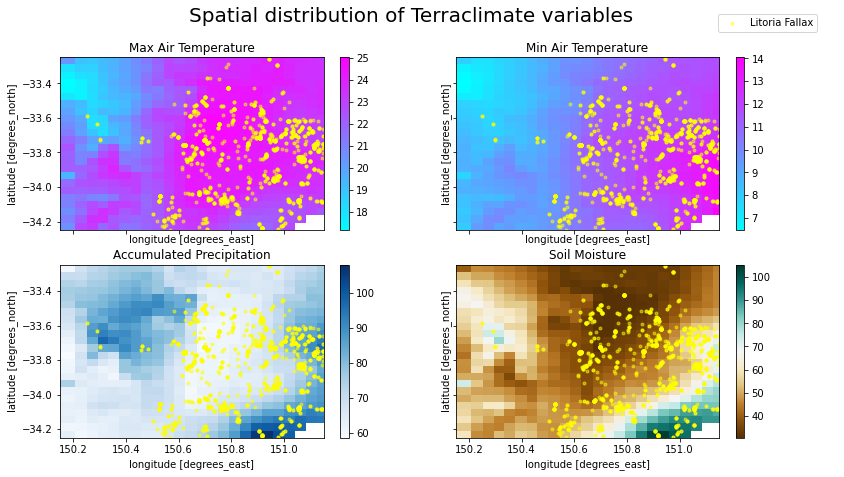

In [ ]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = ["Max Air Temperature", "Min Air Temperature", "Accumulated Precipitation", "Soil Moisture"]
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

Text(0.5, 1.0, 'Training set for Greater Sydney, NSW')

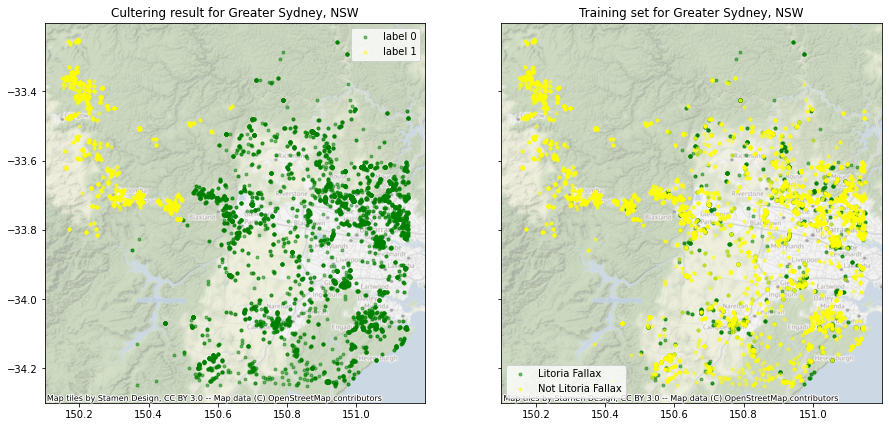

In [ ]:
# Check the distribution of different clusters
fig, ax = plt.subplots(1,2,figsize = (15,15), sharex=True, sharey=True)

ax[0].scatter(model_data[model_data.kmeanlabel == 0].decimalLongitude, model_data[model_data.kmeanlabel == 0].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label="label 0")
ax[0].scatter(model_data[model_data.kmeanlabel == 1].decimalLongitude, model_data[model_data.kmeanlabel == 1].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label="label 1")

ax[0].legend()
cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5)
ax[0].set_title(f"Cultering result for {region_name}")

# Compre with the training set
frog_data = all_frog_data.reset_index(drop=True).assign(key=lambda x: x.index)
filt = frog_data.occurrenceStatus == 1
ax[1].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax[1].scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax[1].legend()
cx.add_basemap(ax[1], crs={'init':'epsg:4326'}, alpha=0.5)
ax[1].set_title(f"Training set for {region_name}")

In [ ]:
# List all the categorical variables
cat_variables = ["species","eventDate","weekday","month","year","kmeanlabel"]
cat_model_data = model_data.loc[:,cat_variables]

#### Cross Tabulation Analysis

In [ ]:
def get_crosstab(cat_model_data,column):
    # Create the crosstab with absolute value
    cross_tab_abs = pd.crosstab(cat_model_data[column], cat_model_data['species'], margins = True)
    # Create the crosstab with percentage value
    cross_tab_per = pd.crosstab(cat_model_data[column], cat_model_data['species'], margins = True, normalize='index')
    # Merge the two crosstabs
    cross_tab = pd.merge(cross_tab_abs,cross_tab_per,on=column).rename(columns={"Crinia Signifera_x":"Crinia Signifera_abs",
                                                                               "Litoria Fallax_x":"Litoria Fallax_abs",
                                                                               "All":"Total",
                                                                               "Crinia Signifera_y":"Crinia Signifera_%",
                                                                               "Litoria Fallax_y":"Litoria Fallax_%"})
    return cross_tab
def get_crosstab_plot(cat_model_data,column):
    # Create the crosstab with percentage value
    cross_tab_per = pd.crosstab(cat_model_data[column], cat_model_data['species'], normalize='index')
    # Plot the crosstab with percentage value
    cross_tab_plot = cross_tab_per.plot(kind="bar",stacked=True,rot=1)
    return cross_tab_plot

In [ ]:
# Perform the cross tabulation analysis for weekday variable
get_crosstab(cat_model_data,"weekday")

species  Crinia Signifera_abs  Litoria Fallax_abs  Total  Crinia Signifera_%  \
weekday                                                                        
1                         892                 399   1291            0.690937   
2                         991                 395   1386            0.715007   
3                         970                 414   1384            0.700867   
4                        1075                 433   1508            0.712865   
5                         934                 439   1373            0.680262   
6                         933                 416   1349            0.691623   
7                         833                 294   1127            0.739130   
All                      6628                2790   9418            0.703759   

species  Litoria Fallax_%  
weekday                    
1                0.309063  
2                0.284993  
3                0.299133  
4                0.287135  
5                0.319738  
6                0.308377  
7                0.260870  
All              0.296241

<AxesSubplot:xlabel='weekday'>

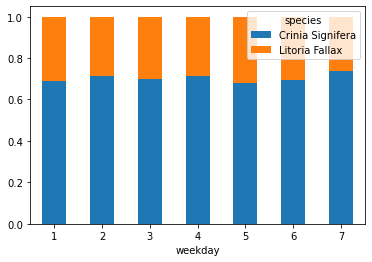

In [ ]:
# Plot the cross tabulation analysis for weekday variable
get_crosstab_plot(cat_model_data,"weekday")

In [ ]:
# Perform the cross tabulation analysis for month variable
get_crosstab(cat_model_data,"month")

species  Crinia Signifera_abs  Litoria Fallax_abs  Total  Crinia Signifera_%  \
month                                                                          
1                         208                 188    396            0.525253   
2                         225                 421    646            0.348297   
3                         389                  58    447            0.870246   
4                         332                  30    362            0.917127   
5                         271                   8    279            0.971326   
6                         682                   4    686            0.994169   
7                         408                   3    411            0.992701   
8                         420                  14    434            0.967742   
9                        1001                 134   1135            0.881938   
10                       1092                 420   1512            0.722222   
11                        972                 791   1763            0.551333   
12                        628                 719   1347            0.466221   
All                      6628                2790   9418            0.703759   

species  Litoria Fallax_%  
month                      
1                0.474747  
2                0.651703  
3                0.129754  
4                0.082873  
5                0.028674  
6                0.005831  
7                0.007299  
8                0.032258  
9                0.118062  
10               0.277778  
11               0.448667  
12               0.533779  
All              0.296241

<AxesSubplot:xlabel='month'>

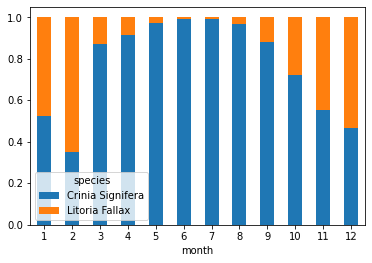

In [ ]:
# Plot the cross tabulation analysis for month variable
get_crosstab_plot(cat_model_data,"month")

In [ ]:
# Perform the cross tabulation analysis for year variable
get_crosstab(cat_model_data,"year")

species  Crinia Signifera_abs  Litoria Fallax_abs  Total  Crinia Signifera_%  \
year                                                                           
2015                      294                 273    567            0.518519   
2016                      348                 349    697            0.499283   
2017                      568                 678   1246            0.455859   
2018                     2945                 712   3657            0.805305   
2019                     2473                 778   3251            0.760689   
All                      6628                2790   9418            0.703759   

species  Litoria Fallax_%  
year                       
2015             0.481481  
2016             0.500717  
2017             0.544141  
2018             0.194695  
2019             0.239311  
All              0.296241

<AxesSubplot:xlabel='year'>

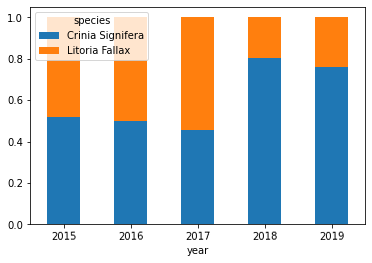

In [ ]:
# Plot the cross tabulation analysis for year variable
get_crosstab_plot(cat_model_data,"year")

In [ ]:
# Perform the cross tabulation analysis for kmeanlabel variable
get_crosstab(cat_model_data,"kmeanlabel")

species     Crinia Signifera_abs  Litoria Fallax_abs  Total  \
kmeanlabel                                                    
0                           5033                2772   7805   
1                           1595                  18   1613   
All                         6628                2790   9418   

species     Crinia Signifera_%  Litoria Fallax_%  
kmeanlabel                                        
0                     0.644843          0.355157  
1                     0.988841          0.011159  
All                   0.703759          0.296241

<AxesSubplot:xlabel='kmeanlabel'>

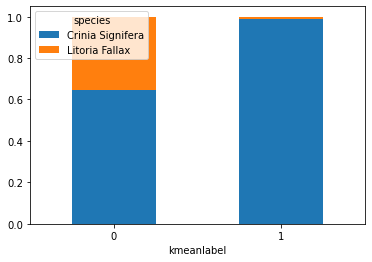

In [ ]:
# Plot the cross tabulation analysis for kmeanlabel variable
get_crosstab_plot(cat_model_data,"kmeanlabel")

#### Chi-square Test

In [ ]:
def get_chi2_test(cat_model_data,column):
    # Random select 1500 samples
    data_temp = cat_model_data.sample(n=1500,random_state=8)
    # Create the cross tabluation table
    cross_table = pd.crosstab(data_temp[column],data_temp['species'])
    # Perform Chi-square test
    stat, p, dof, expected = stats.chi2_contingency(cross_table)
    # Interpret p-value
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

In [ ]:
# Perform the cross tabulation analysis for weekday variable
get_chi2_test(cat_model_data,"weekday")

p value is 0.1375735646638688
Independent (H0 holds true)


In [ ]:
# Perform the cross tabulation analysis for month variable
get_chi2_test(cat_model_data,"month")

p value is 2.8929504393050396e-65
Dependent (reject H0)


In [ ]:
# Perform the cross tabulation analysis for year variable
get_chi2_test(cat_model_data,"year")

p value is 6.862920461718375e-25
Dependent (reject H0)


In [ ]:
# Perform the cross tabulation analysis for kmeanlabel variable
get_chi2_test(cat_model_data,"kmeanlabel")

p value is 3.4315900193240294e-25
Dependent (reject H0)


## Data Modeling

In [ ]:
# List all the variables for data modeling
model_not_X = ["gbifID","eventDate","country","continent","stateProvince","species","occurrenceStatus","key","year"]
y = model_data["occurrenceStatus"]
X = model_data.drop(model_not_X,axis=1)

# Split the data into training and testing sets
random_state = 432
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.30,  random_state = random_state)

In [ ]:
X_Train.head()

decimalLatitude  decimalLongitude    ppt_mean   soil_mean  tmax_mean  \
3367       -34.239091        150.918113  107.949997  105.150002  21.861671   
3551       -33.526270        150.704899   64.666664   31.799999  24.186668   
2857       -33.989000        151.027000   73.750000   63.900002  23.596668   
7007       -33.863800        150.813000   63.549999   43.900002  24.095005   
4472       -34.049286        151.075762   85.533333   83.699997  22.936670   

      tmin_mean  loc_sumsquare  loc_atan2  weekday  month  kmeanlabel  
3367  11.503335     154.753327  -0.223096        6     12           0  
3551  10.926668     154.389045  -0.218898        3     10           0  
2857  12.946669     154.804415  -0.221364        2      7           0  
7007  11.725002     154.568166  -0.220878        1      4           0  
4472  12.831668     154.865231  -0.221675        4      9           0

### Handle Imbalanced Data

In [ ]:
# Compare different method handling imbalanced data
# https://medium.com/@itbodhi/handling-imbalanced-data-sets-in-machine-learning-5e5f33c70163

print('The orignial distribution of y_train is:  {}'.format(Counter(y_Train)))

# Random Under Sampling
rus = RandomUnderSampler(random_state=random_state, sampling_strategy='auto')
X_rus, y_rus = rus.fit_resample(X_Train, y_Train)
print('The distribution of y_train after Random Under Sampling is:  {}'.format(Counter(y_rus)))

# Random Over Sampling
ros = RandomOverSampler(random_state=random_state, sampling_strategy='auto')
X_ros, y_ros = ros.fit_resample(X_Train, y_Train)
print('The distribution of y_train after Random Over Sampling is:  {}'.format(Counter(y_ros)))

# TomekLinks Under Sampling
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl= tl.fit_resample(X_Train, y_Train)
print('The distribution of y_train after TomekLinks Under Sampling is:  {}'.format(Counter(y_tl)))

# SMOTETomek
smt = SMOTETomek(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_Train, y_Train)
print('The distribution of y_train after SMOTETomek Sampling is:  {}'.format(Counter(y_smt)))

# ADASYN
ada = ADASYN(random_state=random_state)
X_ada, y_ada = ada.fit_resample(X_Train, y_Train)
print('The distribution of y_train after ADASYN Sampling is:  {}'.format(Counter(y_ada)))

The orignial distribution of y_train is:  Counter({0: 4609, 1: 1983})
The distribution of y_train after Random Under Sampling is:  Counter({0: 1983, 1: 1983})
The distribution of y_train after Random Over Sampling is:  Counter({0: 4609, 1: 4609})
The distribution of y_train after TomekLinks Under Sampling is:  Counter({0: 4554, 1: 1983})
The distribution of y_train after SMOTETomek Sampling is:  Counter({0: 4564, 1: 4564})
The distribution of y_train after ADASYN Sampling is:  Counter({1: 4880, 0: 4609})


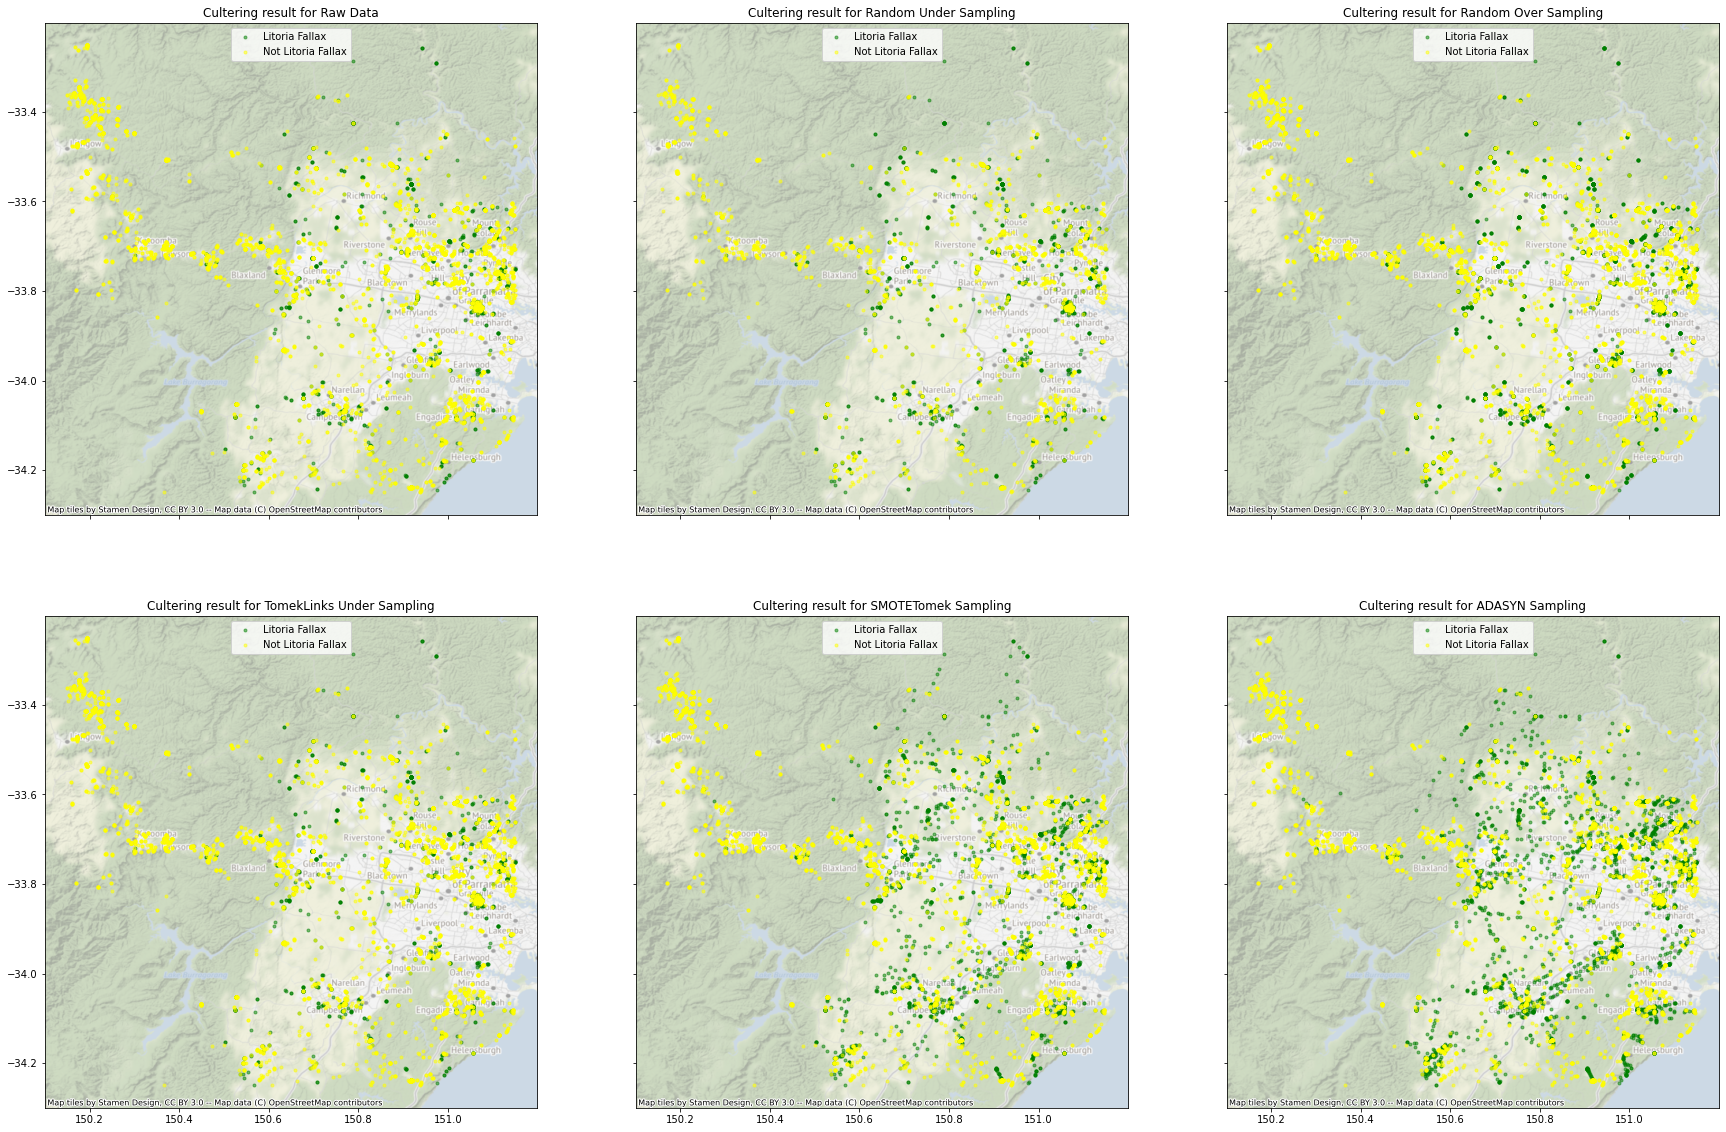

In [ ]:
# Combine X train and y train into new dataframe
data_raw = pd.concat([X_Train, y_Train], axis=1)
data_rus = pd.concat([X_rus, y_rus], axis=1)
data_ros = pd.concat([X_ros, y_ros], axis=1)
data_tl = pd.concat([X_tl, y_tl], axis=1)
data_smt = pd.concat([X_smt, y_smt], axis=1)
data_ada = pd.concat([X_ada, y_ada], axis=1)

# Create lists for the dataframe
balance_list = [data_raw, data_rus,data_ros,data_tl,data_smt,data_ada]
balance_name_list = ["Raw Data", "Random Under Sampling","Random Over Sampling","TomekLinks Under Sampling","SMOTETomek Sampling","ADASYN Sampling"]

n_col = 2
n_row = 3

# Check the distribution of different sampling method
fig, ax = plt.subplots(n_col,n_row,figsize = (30,20), sharex=True, sharey=True)

k=0

for i in range(n_col):
    for j in range(n_row):
        ax[i][j].scatter(balance_list[k][balance_list[k].occurrenceStatus == 1].decimalLongitude, balance_list[k][balance_list[k].occurrenceStatus == 1].decimalLatitude,
                   color = 'green', marker='.', alpha=0.5, label=target_species)
        ax[i][j].scatter(balance_list[k][balance_list[k].occurrenceStatus == 0].decimalLongitude, balance_list[k][balance_list[k].occurrenceStatus == 0].decimalLatitude,
                   color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
        ax[i][j].legend()
        cx.add_basemap(ax[i][j], crs={'init':'epsg:4326'}, alpha=0.5)
        ax[i][j].set_title(f"Cultering result for {balance_name_list[k]}")
        k+=1

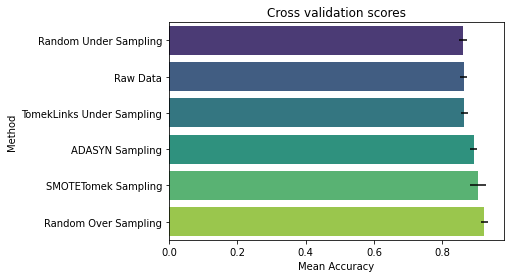

In [ ]:
# Modeling step Test differents algorithms 

X_list = [X_Train,X_rus,X_ros,X_tl,X_smt,X_ada]
y_list = [y_Train,y_rus,y_ros,y_tl,y_smt,y_ada]

kfold = StratifiedKFold(n_splits=10)

cv_results = []

for i in range(len(X_list)) :
    cv_results.append(cross_val_score(RandomForestClassifier(random_state=random_state), X_list[i], y = y_list[i], scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Method":balance_name_list})
cv_res_sort = cv_res.sort_values('CrossValMeans')

g = sns.barplot("CrossValMeans","Method",data = cv_res_sort, palette="viridis",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Choose ROS

### Model Selection - ROS

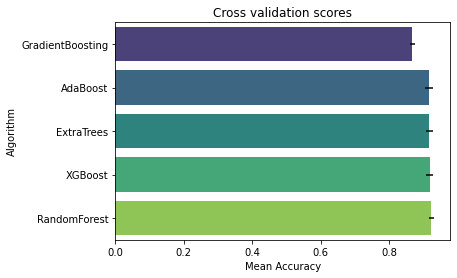

In [ ]:
# Modeling step Test differents algorithms 
classifiers = []

classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_ros, y = y_ros, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["XGBoost","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting"]})
cv_res_sort = cv_res.sort_values('CrossValMeans')

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res_sort, palette="viridis",orient = "h",**{'xerr':cv_std},)
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
cv_res_sort

CrossValMeans  CrossValerrors         Algorithm
4       0.868303        0.008395  GradientBoosting
1       0.917229        0.011038          AdaBoost
3       0.917771        0.010506        ExtraTrees
0       0.918530        0.006592           XGBoost
2       0.923847        0.010008      RandomForest

### Hyper Parameter Tunning - ROS

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier(n_estimators=1000, random_state=random_state)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [10, 50, 100, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10], # default=2
              "min_samples_leaf": [1, 3, 10] # default = 1
                }


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_ros,y_ros)

RFC_best = gsRFC.best_estimator_

# Best score
RFC_best, gsRFC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


(RandomForestClassifier(max_depth=50, max_features=3, n_estimators=1000,
                        random_state=432),
 0.923954910841512)

In [ ]:
print(RandomForestClassifier(max_depth=50, max_features=3, n_estimators=1000,
                        random_state=432).fit(X_ros,y_ros).score(X_Test,y_Test))

0.8630573248407644


### Model Evaluation - ROS

#### Accuracy, Precision, Recall, F1

In [ ]:
# Fit the model
model = RandomForestClassifier(max_depth=50, max_features=3, n_estimators=1000,
                        random_state=432).fit(X_ros,y_ros)

# Make the predictions
y_pred = model.predict(X_Test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_Test, predictions)
precision = precision_score(y_Test, predictions)
recall = recall_score(y_Test, predictions)
f1 = f1_score(y_Test, predictions)

print("accuracy: %.2f%%" % (accuracy * 100.0),"precision: %.2f%%" % (precision * 100.0),"recall: %.2f%%" % (recall * 100.0),"f1: %.2f%%" % (f1 * 100.0))

accuracy: 86.31% precision: 73.60% recall: 81.16% f1: 77.20%


#### ROC AUC

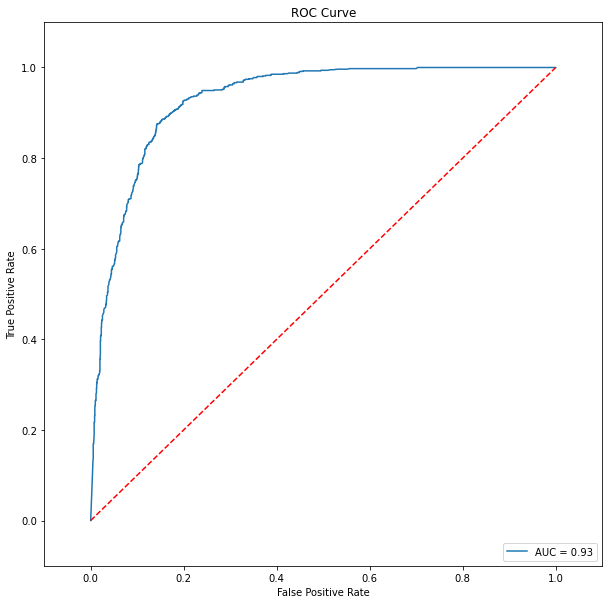

In [ ]:
# Get the probability
y_prob = model.predict_proba(X_Test)[:,1]

# Plot the ROC
fpr, tpr, threshold = roc_curve(y_Test, y_prob)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

#### Feature Importance

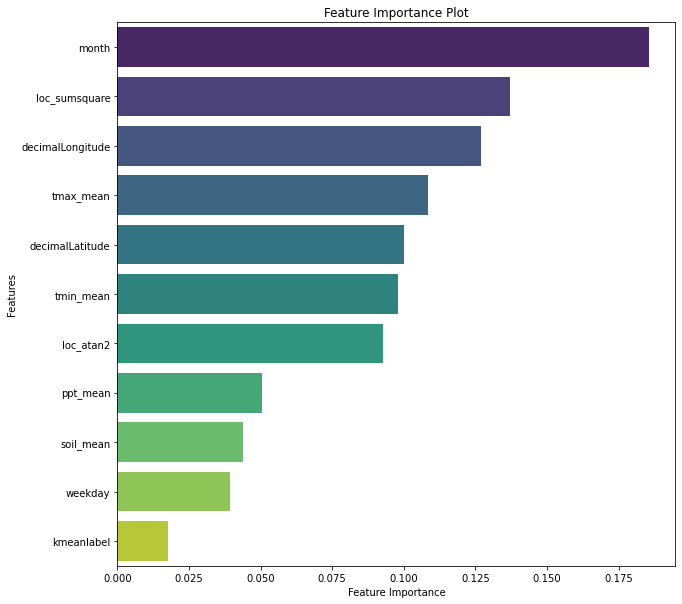

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index= X_ros.columns)
Top = pd.DataFrame(feat_importances).reset_index().sort_values(0,ascending=False).iloc[:,:]

plt.figure(figsize=(10,10))
g = sns.barplot(0,"index",data = Top, palette="viridis",orient = 'h')
g.set_xlabel("Feature Importance")
g.set_ylabel("Features")
g = g.set_title("Feature Importance Plot")